#### Imports

In [66]:
# create some example data
import pandas as pd
import numpy as np
import datetime
import random
# construct and visualize a graph
import networkx as nx
import matplotlib.pyplot as plt
# train a GNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
#  calculate the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
# any torch warning (example purposes)
import warnings
warnings.filterwarnings('ignore')


#### Example data

In [16]:
# Create 3 sources of 1:1 attributes of customers
#   - List features are not incorporated, but could be by
#     implementing an extra pass to express each list item as an edge

N = 1000 # number of 1:1 customer records

In [18]:
# Example data for an online retailer
online_retailer = pd.DataFrame({
    'customer_id': range(1, N + 1),
    'email': [f"{random.choice(['cat', 'dog', 'snake', 'fish', 'bird'])}{i%50}@{random.choice(['one', 'two', 'three', 'four'])}.com" for i in range(1, N + 1)],
    'phone_number': [f'432-010-{i:04}' for i in range(1, N + 1)],
    'purchase_history': [f"product_{random.choice(range(1, 21))}" for _ in range(N)],
    'address': [f"{random.choice(['Central State, Location', 'Forest State, Location', 'Mountain State, Location', 'Lake State, Location'])} {i%200}" for i in range(1, N + 1)],
    'date_of_birth': [f"{i%30+1}/{i%12+1}/198{random.choice(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])}" for i in range(1, N + 1)]
})
online_retailer.head()

,customer_id,email,phone_number,purchase_history,address,date_of_birth
0,1,cat1@two.com,432-010-0001,product_3,"Forest State, Location 1",2/2/1984
1,2,fish2@three.com,432-010-0002,product_19,"Lake State, Location 2",3/3/1980
2,3,snake3@three.com,432-010-0003,product_20,"Central State, Location 3",4/4/1983
3,4,bird4@two.com,432-010-0004,product_19,"Mountain State, Location 4",5/5/1985
4,5,snake5@three.com,432-010-0005,product_9,"Forest State, Location 5",6/6/1989


In [19]:
# Example data for a social media platform
overlap_indices = random.sample(range(1, N + 1), N // 2)
social_media = pd.DataFrame({ 
    'user_id': range(1, N + 1),
    'email': [f"{random.choice(['cat', 'dog', 'snake', 'fish', 'bird'])}{i%50}@{random.choice(['one', 'two', 'three', 'four'])}.com" for i in range(1, N + 1)],
    'username': [f"user_{i}" for i in range(1, N + 1)],
    'friend': [f"user_{random.choice(range(1, N + 1))}" for _ in range(N)],
    'address': [f"{random.choice(['Central State', 'Forest State', 'Mountain State', 'Lake State'])}" for i in range(1, N + 1)],
    'date_of_birth': [online_retailer['date_of_birth'][i-1] if i in overlap_indices else f"{i%28+1}/{i%11+1}/199{random.choice(['0', '1', '2', '3', '4'])}" for i in range(1, N + 1)]
})
social_media.head()

,user_id,email,username,friend,address,date_of_birth
0,1,bird1@two.com,user_1,user_933,Lake State,2/2/1993
1,2,fish2@three.com,user_2,user_548,Forest State,3/3/1980
2,3,bird3@three.com,user_3,user_660,Lake State,4/4/1991
3,4,cat4@three.com,user_4,user_182,Forest State,5/5/1985
4,5,fish5@one.com,user_5,user_410,Central State,6/6/1989


In [20]:
# Example data for an email subscription service
overlap_indices_subs = random.sample(range(1, N + 1), N // 2)
email_subscription = pd.DataFrame({
    'subscriber_id': range(1, N + 1),
    'email': [f"{random.choice(['cat', 'dog', 'snake', 'fish', 'bird'])}{i%50}@{random.choice(['one', 'two', 'three', 'four'])}.com" for i in range(1, N + 1)],
    'subscription_topic': [f"topic_{random.choice(range(1, 11))}" for _ in range(N)],
    'phone_number': [f"432-010-{i:04}" if i in overlap_indices_subs else f"432-010-{i:04}" for i in range(1, N + 1)],
    'address': [online_retailer['address'][i-1] if i in overlap_indices_subs else f"Air State, Location {i%60}" for i in range(1, N + 1)],
    'date_of_birth': [online_retailer['date_of_birth'][i-1] if i in overlap_indices_subs else f"{i%27+1}/{i%10+1}/200{random.choice(['0', '1', '2'])}" for i in range(1, N + 1)]
})
email_subscription.head()

,subscriber_id,email,subscription_topic,phone_number,address,date_of_birth
0,1,bird1@four.com,topic_7,432-010-0001,"Air State, Location 1",2/2/2001
1,2,bird2@three.com,topic_3,432-010-0002,"Air State, Location 2",3/3/2002
2,3,dog3@three.com,topic_6,432-010-0003,"Air State, Location 3",4/4/2001
3,4,snake4@four.com,topic_5,432-010-0004,"Mountain State, Location 4",5/5/1985
4,5,bird5@three.com,topic_4,432-010-0005,"Air State, Location 5",6/6/2000


In [21]:
combined_df = pd.concat([
    online_retailer.assign(source='retailer'),
    social_media.assign(source='social'),
    email_subscription.assign(source='subscription')
], ignore_index=True)
combined_df.head()

,customer_id,email,phone_number,purchase_history,address,date_of_birth,source,user_id,username,friend,subscriber_id,subscription_topic
0,1.0,cat1@two.com,432-010-0001,product_3,"Forest State, Location 1",2/2/1984,retailer,NaN,NaN,NaN,NaN,NaN
1,2.0,fish2@three.com,432-010-0002,product_19,"Lake State, Location 2",3/3/1980,retailer,NaN,NaN,NaN,NaN,NaN
2,3.0,snake3@three.com,432-010-0003,product_20,"Central State, Location 3",4/4/1983,retailer,NaN,NaN,NaN,NaN,NaN
3,4.0,bird4@two.com,432-010-0004,product_19,"Mountain State, Location 4",5/5/1985,retailer,NaN,NaN,NaN,NaN,NaN
4,5.0,snake5@three.com,432-010-0005,product_9,"Forest State, Location 5",6/6/1989,retailer,NaN,NaN,NaN,NaN,NaN


#### Construct a Graph

In [22]:
G = nx.Graph()
for idx, row in combined_df.iterrows():
    G.add_node(idx, label=idx, source=row['source'])

for attribute in ['email', 'phone_number', 'address', 'date_of_birth']:
    attribute_groups = combined_df.groupby(attribute)
    for name, group in attribute_groups:
        ids = group.index.tolist()
        if len(ids) > 1:
            for i in range(len(ids)):
                for j in range(i+1, len(ids)):
                    if not G.has_edge(ids[i], ids[j]):
                        G.add_edge(ids[i], ids[j], attribute=attribute)

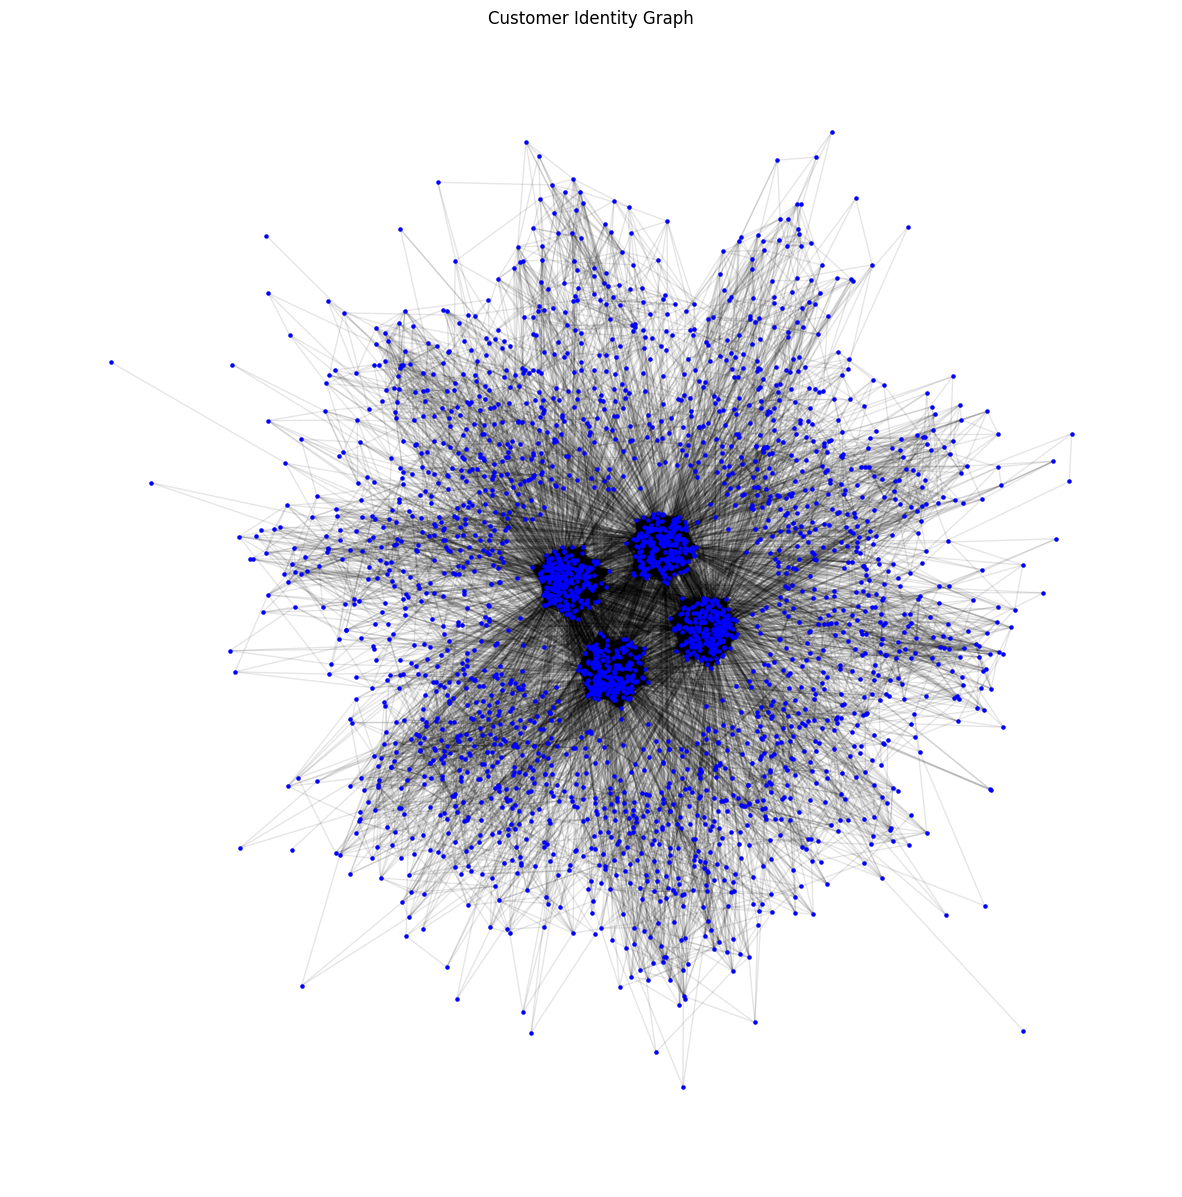

In [23]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, iterations=50)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_nodes(G, pos, node_size=5, node_color="blue")
plt.title("Customer Identity Graph")
plt.axis("off")
plt.show()

#### Feature Extraction

In [67]:
def df_to_tensor(df: pd.DataFrame):
    df_copy = df.copy()
    
    for col in df_copy.columns:
        # If column has numeric type
        if np.issubdtype(df_copy[col].dtype, np.number):
            # Fill NaN values with column mean
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
            df_copy[col] = (df_copy[col] - df_copy[col].mean()) / df_copy[col].std()
        
        # If column has object (likely string) type
        elif df_copy[col].dtype == 'object':
            # Fill NaN with placeholder string
            df_copy[col].fillna("UNKNOWN", inplace=True)
            unique_strings = df_copy[col].unique()
            string_to_num = {string: i for i, string in enumerate(unique_strings)}
            df_copy[col] = df_copy[col].map(string_to_num)
        
        # If column has datetime type
        elif np.issubdtype(df_copy[col].dtype, np.datetime64):
            # Convert dates to ordinal, compute mean, and convert back to date
            mean_ordinal = int(df_copy[col].dropna().apply(lambda x: x.toordinal()).mean())
            mean_date = datetime.date.fromordinal(mean_ordinal)
            df_copy[col].fillna(mean_date, inplace=True)
            min_date = df_copy[col].min()
            df_copy[col] = (df_copy[col] - min_date).dt.days
    
    da = df_copy.values
    # Normalize Data
    data_array = (da - da.mean(axis=0)) / da.std(axis=0)

    # Convert to PyTorch tensor
    features = torch.tensor(data_array, dtype=torch.float)
    return features

feature_matrix = df_to_tensor(combined_df)
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.tensor(feature_matrix, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3000, 12], edge_index=[2, 136826])

#### Setup a GNN

In [24]:
class GNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Proper weight initialization
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First Convolution layer
        x = self.conv1(x, edge_index)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second Convolution layer
        x = self.conv2(x, edge_index)
        x = self.batchnorm2(x)
        x = F.relu(x)
        
        return x  # Return per-node embeddings
    
# Contrastive loss
def contrastive_loss(x1, x2, y, margin=0.5):
    distances = torch.norm(x1 - x2 + 1e-8, p=2, dim=1)
    return torch.mean(y * distances**2 + (1 - y) * F.relu(margin - distances)**2)

#### Train a GNN

In [37]:
input_dim = 12
hidden_dim = 16 # 64
output_dim = 8 # 128
model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    embeddings = model(data)
    
    # Positive pairs (connected nodes)
    pos_pairs = data.edge_index.t()
    x1_pos = embeddings[pos_pairs[:, 0]]
    x2_pos = embeddings[pos_pairs[:, 1]]
    
    # Negative pairs (randomly sample non-connected nodes)
    neg_pairs = np.random.choice(3000, (len(pos_pairs), 2))
    x1_neg = embeddings[neg_pairs[:, 0]]
    x2_neg = embeddings[neg_pairs[:, 1]]
    
    # Compute loss for positive and negative pairs
    loss_pos = contrastive_loss(x1_pos, x2_pos, torch.ones(len(pos_pairs)).to(embeddings.device))
    loss_neg = contrastive_loss(x1_neg, x2_neg, torch.zeros(len(neg_pairs)).to(embeddings.device))
    
    # Total loss
    loss = loss_pos + loss_neg
    loss.backward()

    optimizer.step()
    if (epoch+1) % 100 == 0 or epoch == num_epochs-1 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.7161
Epoch 100, Loss: 0.0749
Epoch 200, Loss: 0.0556
Epoch 300, Loss: 0.0516
Epoch 400, Loss: 0.0541
Epoch 500, Loss: 0.0533


#### Compute Similarities based on GNN Embeddings

In [46]:
embeddings = None
with torch.no_grad(): # non-deterministic
    embeddings = model(data).numpy()
similarities = cosine_similarity(embeddings)

In [65]:
# Comparison 1
customer1 = 0
customer2 = 30
cos_sim = similarities[customer1][customer2]
print(f"Similarity between customer {customer1} and {customer2}: {cos_sim}")
combined_df.iloc[[customer1,customer2]]

Similarity between customer 0 and 30: 0.16043336689472198


,customer_id,email,phone_number,purchase_history,address,date_of_birth,source,user_id,username,friend,subscriber_id,subscription_topic
0,1.0,cat1@two.com,432-010-0001,product_3,"Forest State, Location 1",2/2/1984,retailer,NaN,NaN,NaN,NaN,NaN
30,31.0,cat31@three.com,432-010-0031,product_15,"Central State, Location 31",2/8/1988,retailer,NaN,NaN,NaN,NaN,NaN


In [64]:
# Comparison 2
customer1 = 0
customer2 = 2500
cos_sim = similarities[customer1][customer2]
print(f"Similarity between customer {customer1} and {customer2}: {cos_sim}")
combined_df.iloc[[customer1,customer2]]

Similarity between customer 0 and 2500: 0.5997461080551147


,customer_id,email,phone_number,purchase_history,address,date_of_birth,source,user_id,username,friend,subscriber_id,subscription_topic
0,1.0,cat1@two.com,432-010-0001,product_3,"Forest State, Location 1",2/2/1984,retailer,NaN,NaN,NaN,NaN,NaN
2500,NaN,cat1@two.com,432-010-0501,NaN,"Air State, Location 21",16/2/2001,subscription,NaN,NaN,NaN,501.0,topic_10
